In [2]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intg
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
%matplotlib notebook

1. Matching the U.S. income distribution by GMM

In [3]:
inc = np.loadtxt('usincmoms.txt')
# inc[:,0]


(a) Histogram

<IPython.core.display.Javascript object>


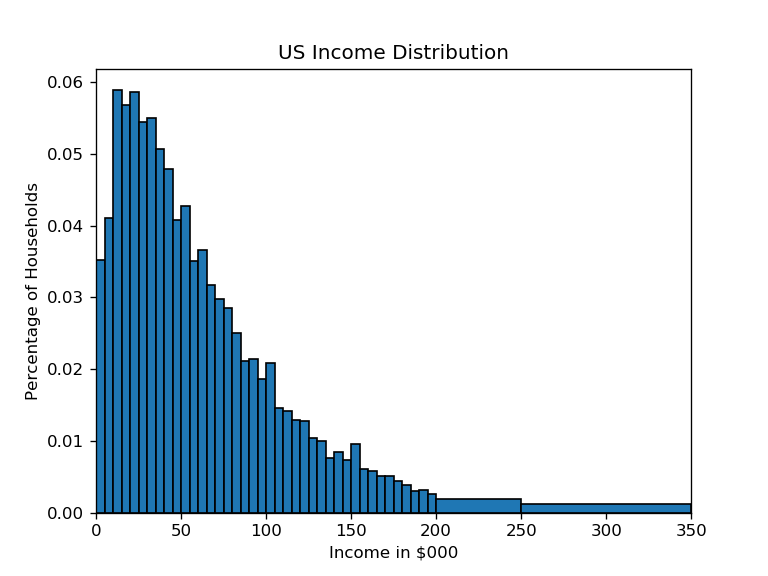

(0, 350)

In [7]:
inc_in_thou = inc[:,1]/1000
weights = inc[:,0]
weights[40] = inc[40,0]/10
weights[41] = inc[41,0]/20
bins = list(range(0,205,5)) + [250,350]

plt.hist(inc_in_thou, bins = bins, weights = weights, edgecolor='black')
plt.title('US Income Distribution')
plt.xlabel(r'Income in $000')
plt.ylabel(r'Percentage of Households')
plt.xlim([0, 350])

(b) Fit lognormal with GMM

In [4]:
bot = np.append(inc[0:40,1]/1000-2.5,[inc[40,1]/1000-25, inc[41,1]/1000-50])
top = np.append(inc[0:40,1]/1000+2.5,[inc[40,1]/1000+25, inc[41,1]/1000+50])

def model_mom(mu, sigma):
    prob_top = sts.lognorm.cdf(top, sigma, scale=np.exp(mu))
    prob_bot = sts.lognorm.cdf(bot, sigma, scale=np.exp(mu))    
    return prob_top-prob_bot

def err_vec(xvals, mu, sigma):
    mom_data = xvals[:,0]
    mom_model = model_mom(mu, sigma)
    err_vec = mom_data - mom_model
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = err.T @ W @ err
    return crit_val


In [5]:
mu_init = np.log(inc[:,1].mean())
sigma_init = np.log(inc[:,1].std())
params_init = np.array([mu_init, sigma_init])
W = np.diag(inc[:,0])
gmm_args = (inc, W)

result= opt.minimize(criterion, params_init, args =(gmm_args), 
                     method='L-BFGS-B', bounds= ((None, None), (1e-10, None)))
mu_gmm, sigma_gmm = result.x
print (result)
print (mu_gmm, sigma_gmm)

      fun: 3.5229542789172412e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.89001090e-07,   6.28820997e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 105
      nit: 17
   status: 0
  success: True
        x: array([ 3.95499503,  1.02336146])
3.95499503494 1.02336146055


<IPython.core.display.Javascript object>


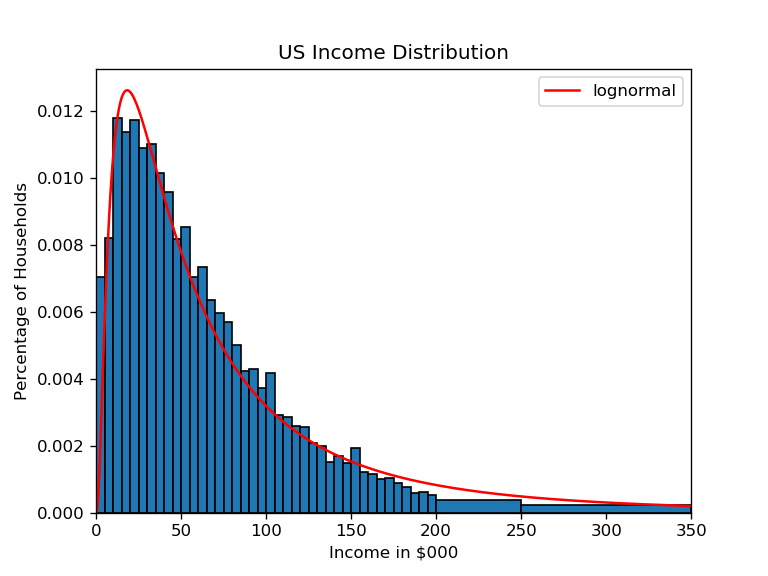

In [8]:
pts = np.linspace(0, 350, 500)
plt.hist(inc_in_thou, bins = bins, weights = weights/5, edgecolor='black')
plt.title('US Income Distribution')
plt.xlabel(r'Income in $000')
plt.ylabel(r'Percentage of Households')
plt.xlim([0, 350])
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)),color = 'r', label = 'lognormal')
plt.legend(loc='upper right')
plt.show()

(c) Fit gamma distribution with GMM

In [32]:


def model_mom2(alpha, beta):
    prob_top = sts.gamma.cdf(top, alpha,scale = beta)
    prob_bot = sts.gamma.cdf(bot, alpha,scale = beta)    
    return prob_top-prob_bot

def err_vec2(xvals, alpha, beta):
    mom_data = xvals[:,0]
    mom_model2 = model_mom2(alpha, beta)
    err_vec2 = mom_data-mom_model2
    return err_vec2

def criterion2(params, *args):
    alpha, beta = params
    xvals, W = args
    err2 = err_vec2(xvals, alpha, beta)
    crit_val2 = err2.T @ W @ err2
    return crit_val2


In [35]:
alpha_init = 3
beta_init = 20
params_init2 = np.array([alpha_init, beta_init])
W = np.diag(inc[:,0])
gmm_args = (inc, W)

result_ga= opt.minimize(criterion2, params_init2, args =(gmm_args), 
                     method='L-BFGS-B', bounds= ((None, None), (1e-10, None)))
alpha_gmm_ga, beta_gmm_ga = result_ga.x
print (result_ga)
print (alpha_gmm_ga, beta_gmm_ga)

      fun: 6.6302592936189468e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.60536568e-07,  -4.80846205e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 16
   status: 0
  success: True
        x: array([  1.43548993,  44.19487582])
1.43548992657 44.1948758236


<IPython.core.display.Javascript object>


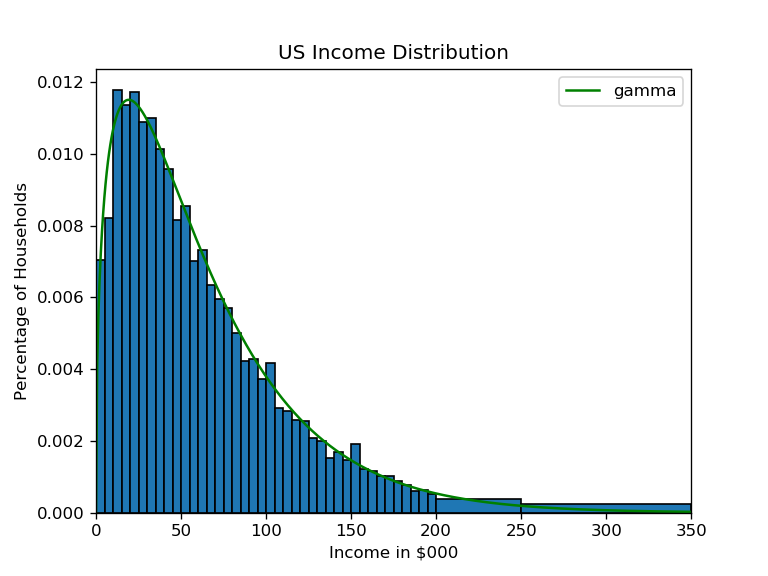

In [36]:
pts = np.linspace(0, 350, 500)
plt.hist(inc_in_thou, bins = bins, weights = weights/5, edgecolor='black')
plt.title('US Income Distribution')
plt.xlabel(r'Income in $000')
plt.ylabel(r'Percentage of Households')
plt.xlim([0, 350])
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm_ga, scale = beta_gmm_ga),color = 'g', label = 'gamma')
plt.legend(loc='upper right')
plt.show()

(d) Compare two fits

<IPython.core.display.Javascript object>


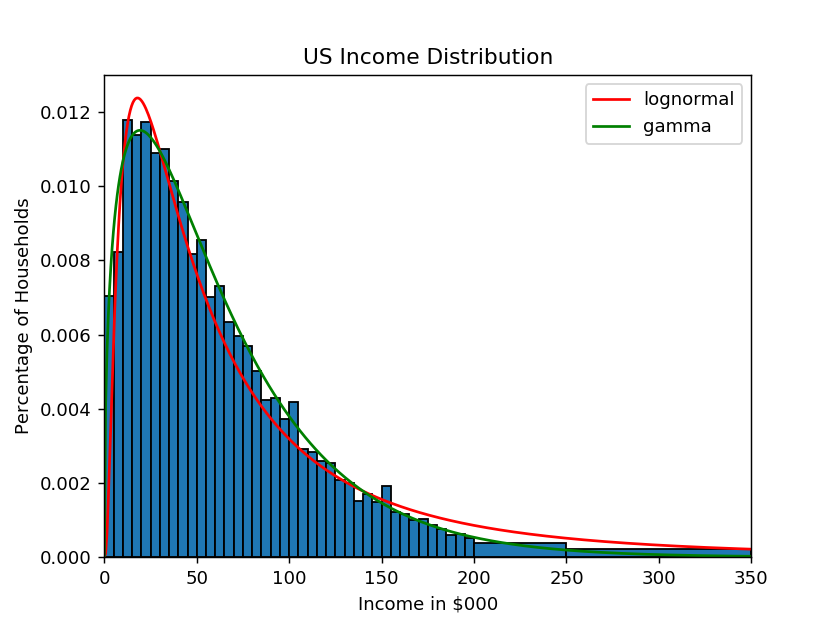

In [11]:
pts = np.linspace(0, 350, 500)
plt.hist(inc_in_thou, bins = bins, weights = weights/5, edgecolor='black')
plt.title('US Income Distribution')
plt.xlabel(r'Income in $000')
plt.ylabel(r'Percentage of Households')
plt.xlim([0, 350])
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)),color = 'r', label = 'lognormal')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm),color = 'g', label = 'gamma')
plt.legend(loc='upper right')
plt.show()

The most precise way to compare two fits is to compare the value of objective function, since the weighting matrix is the same for (b) and (c).
lognorm = , while
GA = .
Gamma distribution fit the data better.

(e) Use two-step estimator

In [39]:

alpha_init = 3
beta_init = 20
params_init2 = np.array([alpha_init, beta_init])
W1 = np.eye(42)


result1st = opt.minimize(criterion2, params_init2, args =(inc, W1), 
                     method='L-BFGS-B', bounds= ((None, None), (1e-10, None)))
alpha_gmm1, beta_gmm1 = result1.x
print (result1)
print (alpha_gmm1, beta_gmm1)

      fun: 0.0003835718949400301
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.62587803e-06,  -1.30933675e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 15
   status: 0
  success: True
        x: array([  1.48127197,  41.29453776])
1.4812719726 41.2945377623


In [40]:
#VCV2 = np.outer(err1.T, err1)/42
# print(VCV2)
#W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
# print(W_hat2)
err_vec_1st = np.reshape(err_vec2(inc, alpha_gmm1, beta_gmm1),(42,1))
omega = (err_vec_1st @ err_vec_1st.T) / inc.shape[0]
W_hat2 = np.linalg.pinv(omega)


In [25]:
def criterion3(params, *args):
    alpha, beta = params
    xvals, W_hat2 = args
    err2 = err_vec2(xvals, alpha, beta)
    crit_val2 = err2.T @ W_hat2 @ err2
    return crit_val2


In [46]:
params_init_e2 = np.array([alpha_gmm1, beta_gmm1])
gmm_args_e2 = (inc, W_hat2)

result2= opt.minimize(criterion2, params_init_e2, args =(gmm_args_e2), method='L-BFGS-B', bounds= ((None, None), (1e-10, None)))
alpha_gmm2, beta_gmm2 = result2.x
print (result2)
print (alpha_gmm2, beta_gmm2)

      fun: 1.5339236044632825e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.07242105e-06,  -1.06095260e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 11
   status: 0
  success: True
        x: array([  3.95800799,  23.68076008])
3.95800799283 23.6807600801


In [48]:
print('change in alpha: ', alpha_gmm2-alpha_gmm_ga)
print('change in beta: ', beta_gmm2-beta_gmm_ga)

change in alpha:  2.52251806626
change in beta:  -20.5141157434


There are some changes in the two parameters. However, since the objective fuction has changed, I cannot compare the goodness of the 2-stp fit versus it of (c) by the minimized function value. However,

<IPython.core.display.Javascript object>


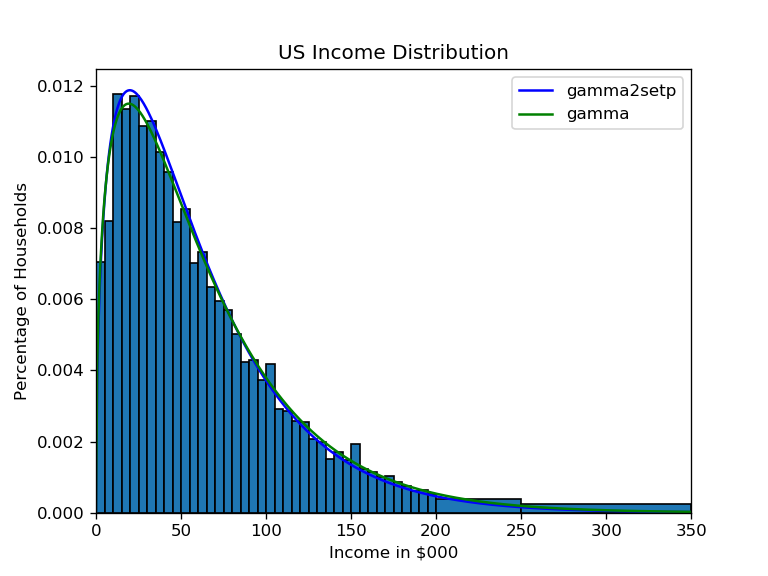

In [51]:
pts = np.linspace(0, 350, 500)
plt.hist(inc_in_thou, bins = bins, weights = weights/5, edgecolor='black')
plt.title('US Income Distribution')
plt.xlabel(r'Income in $000')
plt.ylabel(r'Percentage of Households')
plt.xlim([0, 350])
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm1, scale = beta_gmm1),color = 'b', label = 'gamma2setp')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm_ga, scale = beta_gmm_ga),color = 'g', label = 'gamma')
plt.legend(loc='upper right')
plt.show()

2 Estimating the Brock and Mirman (1972) model by GMM

In [3]:
ms = np.loadtxt('MacroSeries.txt',delimiter=',')

def eq4(alpha,rt,kt):
    z = np.log(rt) - np.log(alpha) + (1-alpha)*np.log(kt)
    z_t = z[0:99]
    z_t_1 = z[1:100]
    return z_t,z_t_1

def err(alpha,beta,rho,mu,x):
    r_t = x[:,3].reshape((100,1))
    k_t = x[:,1].reshape((100,1))
    z_t,z_t1 = eq4(alpha,r_t,k_t)
    k_t1 = x[:,1][1:100]
    c_t1 = x[:,0][1:100]
    c_t = x[:,0][0:99]
    w_t = x[:,2][0:99]
    m1 = z_t1 - rho*z_t - (1-rho)*mu
    m2 = (z_t1 - rho*z_t - (1-rho)*mu)*z_t
    m3 = beta*alpha*np.exp(z_t1)*(k_t1**(alpha-1))*(c_t/c_t1)-1
    m4 = (beta*alpha*np.exp(z_t1)*(k_t1**(alpha-1))*(c_t/c_t1)-1)*w_t
    m = np.array([np.mean(m1), np.mean(m2), np.mean(m3), np.mean(m4)]).reshape(4,1)
    return m

def criterion(params,*args):
    alpha,beta,rho,mu = params
    xvals, W = args
    errv = err(alpha,beta,rho,mu,xvals)
    crit_val = errv.T @ W @ errv
    return crit_val

alpha_init = 0.3
beta_int = 0.9
rho_init = 0.8
mu_init = 12.3
params_init = np.array([alpha_init,beta_int,rho_init,mu_init])
W = np.identity(4)
args = (ms, W)

result1 = opt.minimize(criterion, params_init, args=(args),
                       method='TNC', bounds=((0.001,1), (0.001,1), (-1,1),(0.001,None)))

alpha_gmm1, beta_gmm1, rho_gmm1, mu_gmm1 = result1.x
print ('alpha_gmm = ',alpha_gmm1, 'beta_gmm = ',beta_gmm1, 'rho_gmm = ',rho_gmm1,
       'mu_gmm = ',mu_gmm1, 'criterion function = ',result1.fun)

alpha_gmm =  0.299332010112 beta_gmm =  0.991139087805 rho_gmm =  0.8 mu_gmm =  12.3 criterion function =  [[ 0.00106205]]
